# PriorCVAE on Lotka Volterra-First Param

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import flax.linen as nn

import numpyro
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE_copy.models import CNNEncoder, CNNDecoder, VAE
from priorCVAE_copy.datasets import LVDataset, LVDataset_Beta
from priorCVAE_copy.trainer import VAETrainer
from priorCVAE_copy.losses import SquaredSumAndKL, SumPixelAndKL

import pints_jax as pintsjax

import jax.config as config
config.update("jax_enable_x64", True)

## Generate Data-Uniform Prior on  Parameter
**Beta Prior on First Parameter, Uniform on Second** 

In [5]:
generator = LVDataset()
time_train, xy_train, params_train = generator.simulatedata(10)
time_test, xy_test, params_test = generator.simulatedata(3000)

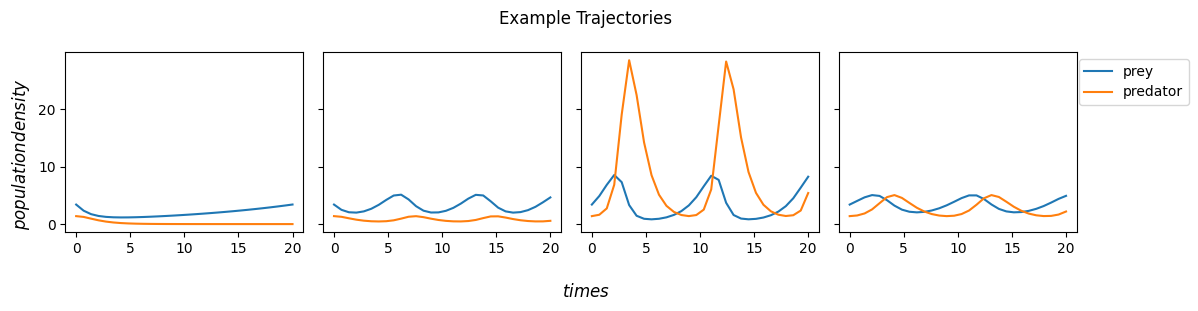

In [6]:
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].plot(time_train[i], xy_train[i,:,0,:],label='prey')
    axs[i].plot(time_train[i], xy_train[i][:,1,:], label='predator')
plt.suptitle('Example Trajectories')
fig.supxlabel('$times$')
fig.supylabel('$population density$')
labels = ['prey', 'predator']
plt.legend(labels, loc='best', bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.show()

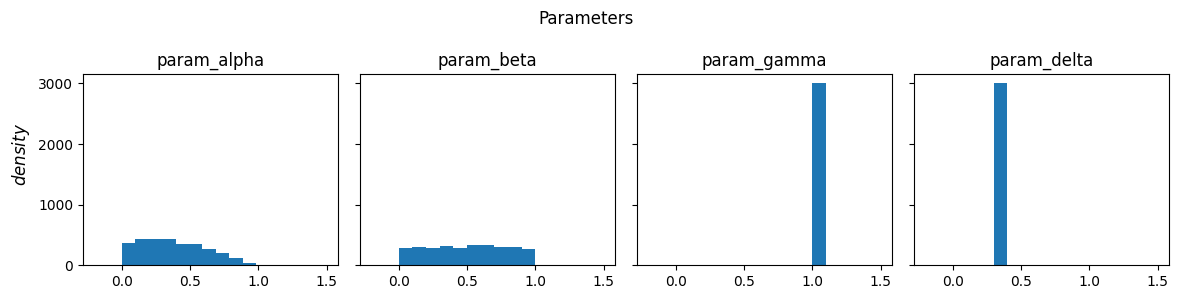

In [7]:
# Check the range of parameter values
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].hist(params_test[:,i])
    args = ['param_alpha','param_beta','param_gamma','param_delta']
    axs[i].set_title(args[i])
plt.suptitle('Parameters')
fig.supylabel('$density$')
plt.tight_layout()
plt.show()

## PriorCVAE Model on Two Parameter
Convolutional layer added with SumPixelAndKL loss.   
Ten different test set is used, each of 2000 data. Model is trained on 500(batch size)* 2000(iterations) * 10 = 10,000,000 data.

In [8]:
# Default setting: Valid Padding
# Trained with fixed initial value (log30, log4)
cnn_encoder = CNNEncoder(conv_features=[8,12], hidden_dim=10, latent_dim=8, conv_activation=nn.tanh, conv_kernel_size=[[4,1], [3,2]], conv_stride=[(2,1), (1,1)])
cnn_decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)
model = VAE(cnn_encoder, cnn_decoder)
optimizer= optax.adam(learning_rate=1e-3)

trainer = VAETrainer(model, optimizer, loss=SumPixelAndKL(conditional=True))

In [9]:
trainer.init_params(xy_train[0][jnp.newaxis,:,:,:],c=params_train[0][jnp.newaxis,:])
loss_1 = []
loss_2 = []
for i in range(5):
    time_test, xy_test, params_test = generator.simulatedata(2000)
    test_set = (time_test, xy_test, params_test)
    loss_vals, test_vals, time_taken = trainer.train(generator, test_set, 2000, 500)
    loss_1 = loss_1 + loss_vals
    loss_2 = loss_2 + test_vals

[    1] training loss: 229.610, test loss: 449.830
[   11] training loss: 187.873, test loss: 277.966
[   21] training loss: 158.649, test loss: 174.252
[   31] training loss: 123.420, test loss: 141.952
[   41] training loss: 147.766, test loss: 132.839
[   51] training loss: 118.145, test loss: 127.874
[   61] training loss: 125.579, test loss: 124.136
[   71] training loss: 113.960, test loss: 121.024
[   81] training loss: 112.455, test loss: 118.414
[   91] training loss: 107.360, test loss: 116.314
[  101] training loss: 109.947, test loss: 114.581
[  111] training loss: 125.476, test loss: 113.179
[  121] training loss: 107.715, test loss: 112.102
[  131] training loss: 109.432, test loss: 111.244
[  141] training loss: 108.832, test loss: 110.579
[  151] training loss: 120.243, test loss: 110.067
[  161] training loss: 95.488, test loss: 109.645
[  171] training loss: 116.971, test loss: 109.326
[  181] training loss: 92.322, test loss: 109.032
[  191] training loss: 122.997, t

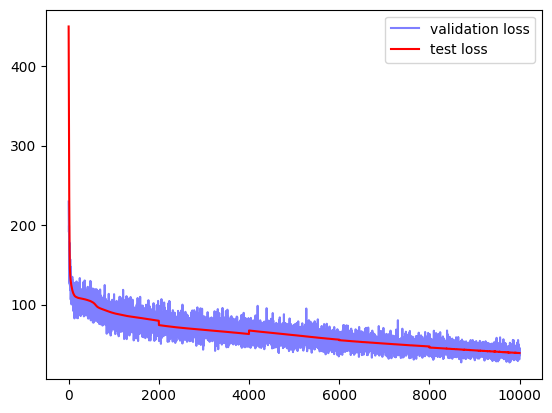

In [10]:
plt.plot(range(len(loss_1)), loss_1, color='blue', label='validation loss',alpha = 0.5,)
plt.plot(range(len(loss_2)),loss_2, color='red', label='test loss')
plt.legend()
plt.show()

In [11]:
for i in range(5):
    time_test, xy_test, params_test = generator.simulatedata(2000)
    test_set = (time_test, xy_test, params_test)
    loss_vals, test_vals, time_taken = trainer.train(generator, test_set, 2000, 500)
    loss_1 = loss_1 + loss_vals
    loss_2 = loss_2 + test_vals

[    1] training loss: 33.622, test loss: 39.845
[   11] training loss: 43.290, test loss: 39.943
[   21] training loss: 46.745, test loss: 39.947
[   31] training loss: 40.509, test loss: 39.811
[   41] training loss: 45.890, test loss: 39.822
[   51] training loss: 39.494, test loss: 39.796
[   61] training loss: 44.908, test loss: 39.656
[   71] training loss: 27.709, test loss: 39.718
[   81] training loss: 34.395, test loss: 39.660
[   91] training loss: 40.897, test loss: 39.652
[  101] training loss: 44.778, test loss: 39.576
[  111] training loss: 34.600, test loss: 39.579
[  121] training loss: 38.756, test loss: 39.621
[  131] training loss: 36.088, test loss: 39.475
[  141] training loss: 41.029, test loss: 39.494
[  151] training loss: 32.516, test loss: 39.436
[  161] training loss: 34.071, test loss: 39.457
[  171] training loss: 34.246, test loss: 39.389
[  181] training loss: 36.157, test loss: 39.285
[  191] training loss: 39.682, test loss: 39.320
[  201] training los

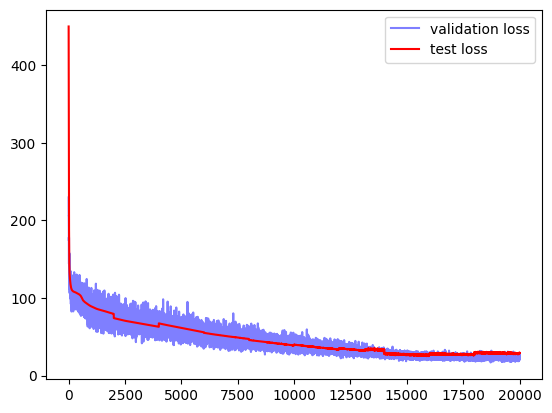

In [18]:
plt.plot(range(len(loss_1)), loss_1, color='blue', label='validation loss',alpha = 0.5,)
plt.plot(range(len(loss_2)),loss_2, color='red', label='test loss')
plt.legend()
plt.show()

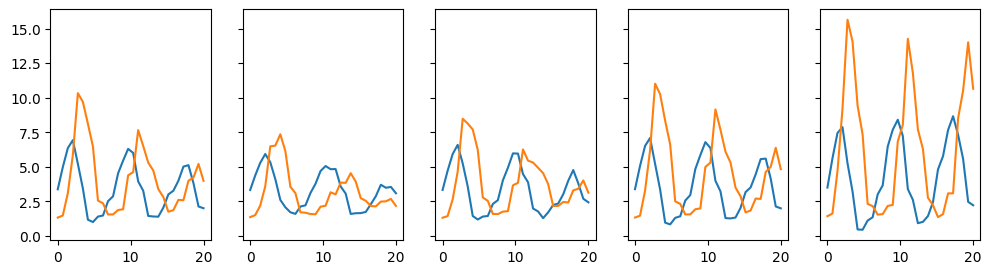

In [12]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (50, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c = jax.random.uniform(c_rng, shape=(50,4))
c = c.at[:,1:].set([0.15,1,.3])
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, axs = plt.subplots(1,5, sharex=True, sharey=True, figsize=(12,3))
for i in range(5):
    axs[i].plot(time_train[i], out[i,:,0,:],label='prey')
    axs[i].plot(time_train[i], out[i][:,1,:], label='predator')

plt.show()

In [13]:
# Check performance for low end values.
model = pintsjax.toy.LotkaVolterraModel()
times = np.linspace(0,20,30)
params_1 = np.array([0.1,0.15,1,.3])
params_2 = np.array([0.2,0.15,1,.3])
values_1 = model.simulate(params_1, times)
values_2 = model.simulate(params_2, times)

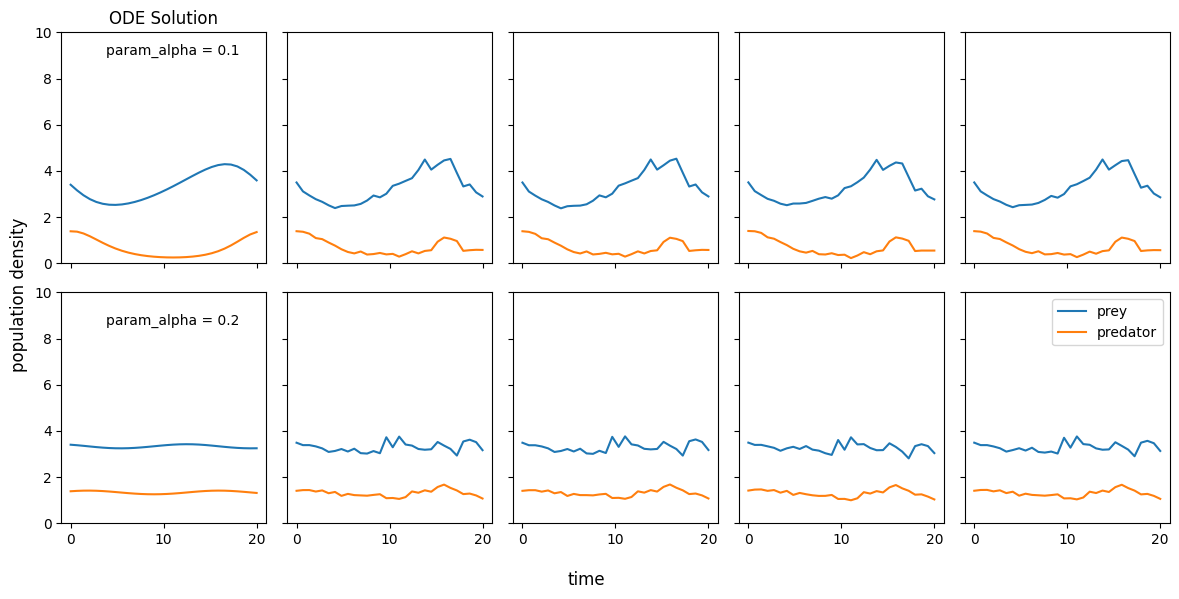

In [14]:
# Fixed parameter - expect the same results
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (10, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c_1 = np.array([0.1,0.15,1,.3])
c_1 = jnp.tile(c_1, (10,1))
z_c_1 = jnp.concatenate([z, c_1], axis=-1)
out_1 = decoder.apply({'params': decoder_params}, z_c_1)       

c_2 = np.array([0.2,0.15,1,.3])
c_2 = jnp.tile(c_2, (10,1))
z_c_2 = jnp.concatenate([z, c_2], axis=-1)
out_2 = decoder.apply({'params': decoder_params}, z_c_2)      

fig, axs = plt.subplots(2,5, sharex=True, sharey=True, figsize=(12,6))
axs[0,0].plot(times, values_1[:,0], label = 'prey')
axs[0,0].plot(times, values_1[:,1], label = 'predator')
axs[0,0].title.set_text('ODE Solution')
axs[1,0].plot(times, values_2[:,0], label = 'prey')
axs[1,0].plot(times, values_2[:,1], label = 'predator')
for i in range(4):
    axs[0,i+1].plot(time_train[i], out_1[i,:,0,:],label='prey')
    axs[0,i+1].plot(time_train[i], out_1[i][:,1,:], label='predator')
    axs[1,i+1].plot(time_train[i], out_2[i,:,0,:],label='prey')
    axs[1,i+1].plot(time_train[i], out_2[i][:,1,:], label='predator')
plt.legend()
plt.figtext(0.1,0.9,'param_alpha = 0.1')
plt.figtext(0.1,0.45,'param_alpha = 0.2')
plt.ylim(0,10)
fig.supxlabel('time')
fig.supylabel('population density')
plt.tight_layout()
plt.show()

## Generate Data-Beta Prior on Two Param

In [15]:
generator_b = LVDataset_Beta()
time_train_b, xy_train_b, params_train_b = generator_b.simulatedata(10)
time_test_b, xy_test_b, params_test_b = generator_b.simulatedata(5000)

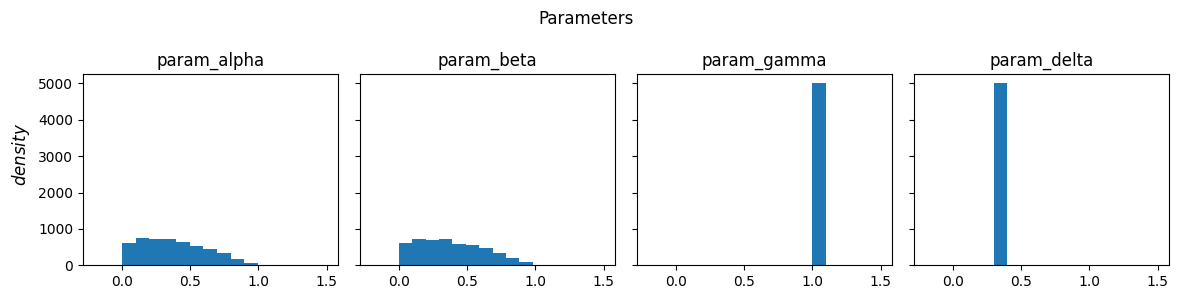

In [20]:
# Check the range of parameter values
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].hist(params_test_b[:,i])
    args = ['param_alpha','param_beta','param_gamma','param_delta']
    axs[i].set_title(args[i])
plt.suptitle('Parameters')
fig.supylabel('$density$')
plt.tight_layout()
plt.show()

## PriorCVAE Model on Two Parameter
Using the same configuration of CNN as before, the same model and optimizer.  
**Note: this is trained with 20 test sets**

In [21]:
# Default setting: Valid Padding
# Trained with fixed initial value (log30, log4)
cnn_encoder = CNNEncoder(conv_features=[8,12], hidden_dim=10, latent_dim=8, conv_activation=nn.tanh, conv_kernel_size=[[4,1], [3,2]], conv_stride=[(2,1), (1,1)])
cnn_decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)
model = VAE(cnn_encoder, cnn_decoder)
optimizer= optax.adam(learning_rate=1e-3)

In [23]:
trainer_b = VAETrainer(model, optimizer, loss=SumPixelAndKL(conditional=True))

trainer_b.init_params(xy_train_b[0][jnp.newaxis,:,:,:],c=params_train_b[0][jnp.newaxis,:])
loss_1_b = []
loss_2_b = []
for i in range(10):
    time_test, xy_test, params_test = generator_b.simulatedata(2000)
    test_set = (time_test, xy_test, params_test)
    loss_vals, test_vals, time_taken = trainer_b.train(generator_b, test_set, 2000, 500)
    loss_1_b = loss_1_b + loss_vals
    loss_2_b = loss_2_b + test_vals

[    1] training loss: 323.147, test loss: 736.409
[   11] training loss: 235.390, test loss: 424.337
[   21] training loss: 176.063, test loss: 238.720
[   31] training loss: 160.702, test loss: 174.177
[   41] training loss: 155.836, test loss: 157.909
[   51] training loss: 145.585, test loss: 151.136
[   61] training loss: 132.588, test loss: 146.251
[   71] training loss: 125.917, test loss: 142.074
[   81] training loss: 128.510, test loss: 138.377
[   91] training loss: 137.217, test loss: 135.179
[  101] training loss: 130.636, test loss: 132.372
[  111] training loss: 121.728, test loss: 129.860
[  121] training loss: 113.250, test loss: 127.620
[  131] training loss: 116.312, test loss: 125.562
[  141] training loss: 114.497, test loss: 123.650
[  151] training loss: 118.086, test loss: 121.865
[  161] training loss: 110.516, test loss: 120.237
[  171] training loss: 130.057, test loss: 118.753
[  181] training loss: 117.458, test loss: 117.428
[  191] training loss: 119.966,

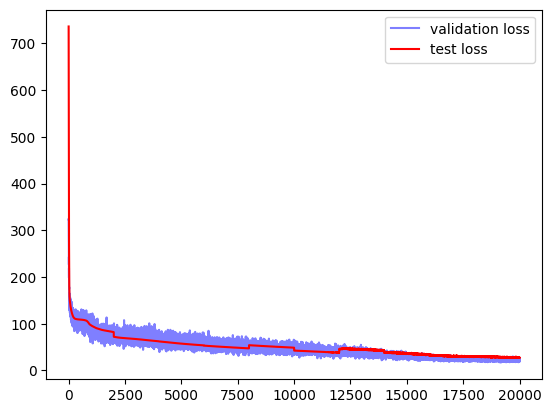

In [24]:
plt.plot(range(len(loss_1_b)), loss_1_b, color='blue', label='validation loss',alpha = 0.5,)
plt.plot(range(len(loss_2_b)),loss_2_b, color='red', label='test loss')
plt.legend()
plt.show()

In [26]:
for i in range(10):
    time_test, xy_test, params_test = generator_b.simulatedata(2000)
    test_set = (time_test, xy_test, params_test)
    loss_vals, test_vals, time_taken = trainer_b.train(generator_b, test_set, 2000, 500)
    loss_1_b = loss_1_b + loss_vals
    loss_2_b = loss_2_b + test_vals

[    1] training loss: 21.079, test loss: 29.194
[   11] training loss: 24.918, test loss: 30.311
[   21] training loss: 21.970, test loss: 30.091
[   31] training loss: 22.599, test loss: 28.430
[   41] training loss: 17.430, test loss: 29.983
[   51] training loss: 22.905, test loss: 29.582
[   61] training loss: 24.029, test loss: 28.718
[   71] training loss: 21.763, test loss: 29.326
[   81] training loss: 19.549, test loss: 29.340
[   91] training loss: 25.924, test loss: 28.824
[  101] training loss: 21.755, test loss: 29.051
[  111] training loss: 20.923, test loss: 29.121
[  121] training loss: 19.245, test loss: 29.772
[  131] training loss: 20.654, test loss: 29.030
[  141] training loss: 21.634, test loss: 29.536
[  151] training loss: 23.325, test loss: 30.252
[  161] training loss: 24.857, test loss: 28.499
[  171] training loss: 21.101, test loss: 29.396
[  181] training loss: 26.770, test loss: 29.603
[  191] training loss: 20.842, test loss: 29.287
[  201] training los

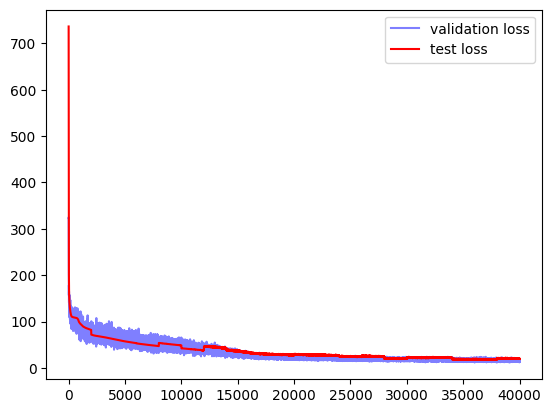

In [27]:
plt.plot(range(len(loss_1_b)), loss_1_b, color='blue', label='validation loss',alpha = 0.5,)
plt.plot(range(len(loss_2_b)),loss_2_b, color='red', label='test loss')
plt.legend()
plt.show()

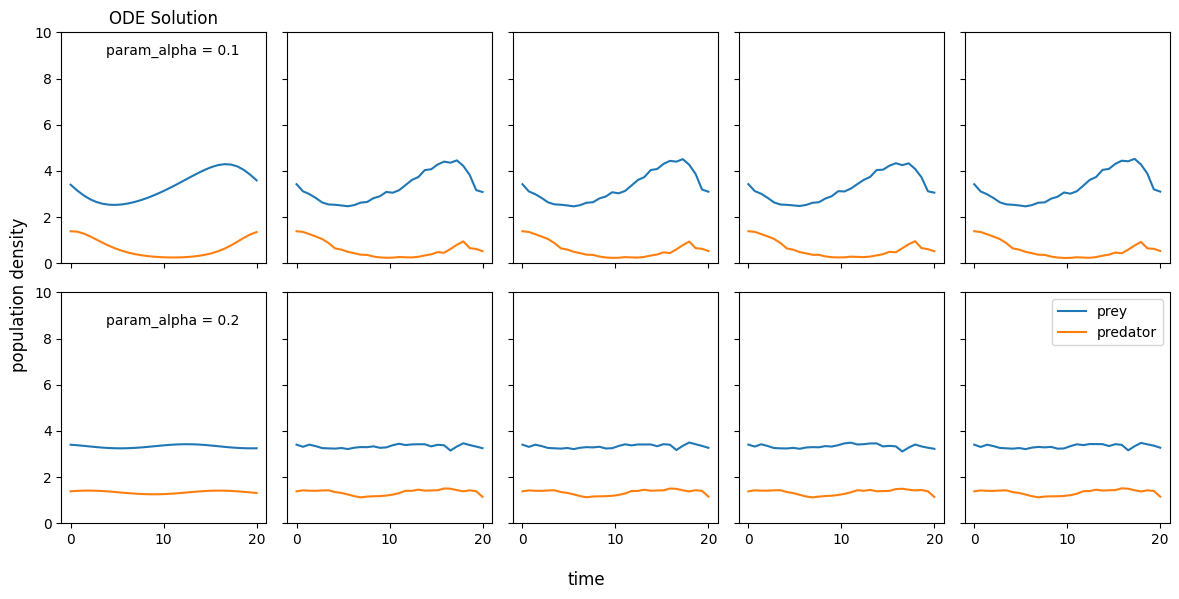

In [28]:
# Check performance of low end parameter values
# Fixed parameter - expect the same results
decoder_params = trainer_b.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (10, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c_1 = np.array([0.1,0.15,1,.3])
c_1 = jnp.tile(c_1, (10,1))
z_c_1 = jnp.concatenate([z, c_1], axis=-1)
out_1 = decoder.apply({'params': decoder_params}, z_c_1)       

c_2 = np.array([0.2,0.15,1,.3])
c_2 = jnp.tile(c_2, (10,1))
z_c_2 = jnp.concatenate([z, c_2], axis=-1)
out_2 = decoder.apply({'params': decoder_params}, z_c_2)      

fig, axs = plt.subplots(2,5, sharex=True, sharey=True, figsize=(12,6))
axs[0,0].plot(times, values_1[:,0], label = 'prey')
axs[0,0].plot(times, values_1[:,1], label = 'predator')
axs[0,0].title.set_text('ODE Solution')
axs[1,0].plot(times, values_2[:,0], label = 'prey')
axs[1,0].plot(times, values_2[:,1], label = 'predator')
for i in range(4):
    axs[0,i+1].plot(time_train_b[i], out_1[i,:,0,:],label='prey')
    axs[0,i+1].plot(time_train_b[i], out_1[i][:,1,:], label='predator')
    axs[1,i+1].plot(time_train_b[i], out_2[i,:,0,:],label='prey')
    axs[1,i+1].plot(time_train_b[i], out_2[i][:,1,:], label='predator')
plt.legend()
plt.figtext(0.1,0.9,'param_alpha = 0.1')
plt.figtext(0.1,0.45,'param_alpha = 0.2')
plt.ylim(0,10)
fig.supxlabel('time')
fig.supylabel('population density')
plt.tight_layout()
plt.show()